In [211]:
#!/usr/bin/env python3 -u
# Copyright (c) 2017-present, Facebook, Inc.
# All rights reserved.
#
# This source code is licensed under the license found in the LICENSE file in
# the root directory of this source tree.
from __future__ import print_function

import argparse
import csv
import os

import numpy as np
import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import models
from utils import progress_bar
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from tqdm import tqdm

# parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Training')
# parser.add_argument('--lr', default=0.1, type=float, help='learning rate')
# parser.add_argument('--resume', '-r', action='store_true',
#                     help='resume from checkpoint')
# parser.add_argument('--model', default="ResNet18", type=str,
#                     help='model type (default: ResNet18)')
# parser.add_argument('--name', default='0', type=str, help='name of run')
# parser.add_argument('--seed', default=0, type=int, help='random seed')
# parser.add_argument('--batch-size', default=128, type=int, help='batch size')
# parser.add_argument('--epoch', default=200, type=int,
#                     help='total epochs to run')
# parser.add_argument('--no-augment', dest='augment', action='store_false',
#                     help='use standard augmentation (default: True)')
# parser.add_argument('--decay', default=1e-4, type=float, help='weight decay')
# parser.add_argument('--alpha', default=1., type=float,
#                     help='mixup interpolation coefficient (default: 1)')
# args = parser.parse_args()

params = {
    "lr": .01,
    "resume": True,
    "model": "ResNet18",
    "name": "mixup-128-AdvsTrain-Eps(.32, .08)",
    "seed": 10,
    "batch_size": 128,
    "decay": 1e-4, 
    "augment": True,
    "epoch": 200,
#     "no_augment": False,
    "alpha": 1.,
}

# %cd ../../

In [212]:

# checkpoint = torch.load('./checkpoint/ckpt.t7' + params["name"] + '_'
#                             + str(params["seed"]), map_location='cpu')

# net_SampEps_32_10 = checkpoint['net']
# net_SampEps_32_10.cuda()

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): PreActBlock(
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (shortcut): Sequential()
      )
      (1): PreActBlock(
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

# Loading Data

In [202]:



use_cuda = torch.cuda.is_available()

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

if params["seed"] != 0:
    torch.manual_seed(params["seed"])

# Data
print('==> Preparing data..')
if params["augment"]:
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])
else:
    print("no augmentation")
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = datasets.CIFAR10(root='./data', train=True, download=False,
                            transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=params["batch_size"],
                                          shuffle=True, num_workers=8)

testset = datasets.CIFAR10(root='./data', train=False, download=False,
                           transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=8)

==> Preparing data..


In [222]:
x, y = next(iter(trainloader))
x.shape, y.shape

(torch.Size([128, 3, 32, 32]), torch.Size([128]))

# Creating Model 

In [203]:
# Model
if params["resume"]:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.t7' + params["name"] + '_'
                            + str(params["seed"]), map_location='cpu')
    
    net = checkpoint['net']
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch'] + 1
    rng_state = checkpoint['rng_state']
    torch.set_rng_state(rng_state)
else:
    print('==> Building model..')
    net = models.__dict__[params["model"]]()

if not os.path.isdir('results'):
    os.mkdir('results')
logname = ('results/log_' + net.__class__.__name__ + '_' + params["name"] + '_'
           + str(params["seed"]) + '.csv')

if use_cuda:
    net = torch.nn.DataParallel(net)
    net.to(f'cuda:{net.device_ids[0]}')
    print(torch.cuda.device_count())
    cudnn.benchmark = True
    print('Using CUDA..')

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=params["lr"], momentum=0.9,
                      weight_decay=params["decay"])

==> Building model..
3
Using CUDA..


# Helping functions

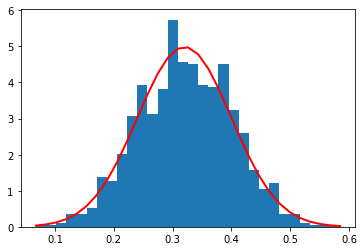

In [185]:
import matplotlib.pyplot as plt
mu, sigma = .32, .08
s = np.random.normal(mu, sigma, 1000)
count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')
plt.show()

In [204]:
def advs_mix_err():
    

def mixup_data(x, y, alpha=1.0, use_cuda=True, advs_train=False, epsilon=.35):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)
    

    
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    
    
    
    if advs_train:
        
        x_b = x[index, :]
        
        x_b.requires_grad_(True)
        x.requires_grad_(True)
        
        out_a = net(x)
        loss_a = criterion(out_a, y_a)
        optimizer.zero_grad()
        loss_a.backward()
        
        if type(epsilon) == tuple:
            epsilon = np.random.beta(epsilon[0], epsilon[1])
            
        
        err = torch.zeros_like(x)
        with torch.no_grad():
            err += epsilon * lam * x.grad.sign()

        out_b = net(x_b)
        loss_b = criterion(out_b, y_b)
        optimizer.zero_grad()
        loss_b.backward()
        
        with torch.no_grad():
            err += epsilon * (1 - lam) * x_b.grad.sign()
            
        mixed_x += err
        
        
        

    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


def mixup_criterion_nMixes(criterion, pred, mixed_targs, wts):
    '''Returns total criterion for total mixed images'''
    
    # accumulate total criterion as weighted sum of shuffled targets, weighted with wts 
    total_criterion = 0
    for i in range(len(wts)):
        total_criterion += wts[i]*criterion(pred, mixed_targs[:,i])
    return(total_criterion)


def train_mixup(epoch, advs_train=False, epsilon=.35):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    reg_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
                 
        inputs, targets_a, targets_b, lam = mixup_data(inputs, targets,
                                                       params["alpha"], use_cuda, 
                                                       advs_train=advs_train, epsilon=epsilon)
        
        inputs, targets_a, targets_b = map(Variable, (inputs,
                                                      targets_a, targets_b))
        outputs = net(inputs)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (lam * predicted.eq(targets_a.data).cpu().sum().float()
                    + (1 - lam) * predicted.eq(targets_b.data).cpu().sum().float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        progress_bar(batch_idx, len(trainloader),
                     'Loss: %.3f | Reg: %.5f | Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), reg_loss/(batch_idx+1),
                        100.*correct/total, correct, total))
    return (train_loss/batch_idx, reg_loss/batch_idx, 100.*correct/total)


def train_normal(epochs, advs_train=False , epsilon=.35, alpha=0.5):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    reg_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        
        outputs_normal = net(inputs)
        loss_normal = criterion(outputs_normal, targets)
        
        if advs_train:
            inputs_advs = fgsm(inputs, targets, eps=epsilon)
            outputs_advs = net(inputs_advs)
            loss_advs = criterion(outputs_advs, targets)
            loss = ((1 - alpha) * loss_advs) + (alpha * loss_normal)
        else:
            loss = loss_normal
        
        optimizer.zero_grad()
        loss.backward()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs_normal.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum().float()

        optimizer.step()

        progress_bar(batch_idx, len(trainloader),
                     'Loss: %.3f | Reg: %.5f | Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), reg_loss/(batch_idx+1),
                        100.*correct/total, correct, total))
        
    return (train_loss/batch_idx, reg_loss/batch_idx, 100.*correct/total)


def fgsm(x, y, eps=.35):
    
    x.requires_grad_(True)
    out = net(x)
    loss = criterion(out, y)
    optimizer.zero_grad()
    loss.backward()
        
    with torch.no_grad():
        err = eps * x.grad.sign()    
        x_advs = x + err

    return x_advs

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        progress_bar(batch_idx, len(testloader),
                     'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                     % (test_loss/(batch_idx+1), 100.*correct/total,
                        correct, total))
    acc = 100.*correct/total
    if acc > best_acc:
        best_acc = acc
        checkpoint(acc, epoch)

        
    return (test_loss/batch_idx, 100.*correct/total)


def checkpoint(acc, epoch):
    # Save checkpoint.
    print('Saving..')
    state = {
        'net': net,
        'acc': acc,
        'epoch': epoch,
        'rng_state': torch.get_rng_state()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/ckpt.t7' + params["name"] + '_'
               + str(params["seed"]))


def adjust_learning_rate(optimizer, epoch):
    """decrease the learning rate at 100 and 150 epoch"""
    lr = params["lr"]
    if epoch >= 100:
        lr /= 10
    if epoch >= 150:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Training the model

In [205]:
if not os.path.exists(logname):
    with open(logname, 'w') as logfile:
        logwriter = csv.writer(logfile, delimiter=',')
        logwriter.writerow(['epoch', 'train loss', 'reg loss', 'train acc',
                            'test loss', 'test acc'])

mu = .32
sig = .08
for epoch in range(start_epoch, params["epoch"]):
    train_loss, reg_loss, train_acc = train_mixup(epoch, advs_train=True, epsilon=(1.,1.))
    test_loss, test_acc = test(epoch)
    adjust_learning_rate(optimizer, epoch)
    with open(logname, 'a') as logfile:
        logwriter = csv.writer(logfile, delimiter=',')
        logwriter.writerow([epoch, train_loss, reg_loss, train_acc, test_loss,
                            test_acc])


Epoch: 0
 [=====================================================================================>]  Step: 163ms | Tot: 59s523ms | Loss: 2.305 | Reg: 0.00000 | Acc: 11.703% (5851/50000 391/391 


<ipython-input-204-8f50c73e32b1>:160: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, targets = Variable(inputs, volatile=True), Variable(targets)


 [=====================================================================================>]  Step: 40ms | Tot: 3s623ms | Loss: 2.177 | Acc: 24.730% (2473/10000 100/100 0 ===================================================>............................]  Step: 37ms | Tot: 2s396ms | Loss: 2.178 | Acc: 24.779% (1685/6800 68/100 >............]  Step: 41ms | Tot: 3s101ms | Loss: 2.178 | Acc: 24.644% (2144/8700 87/100 ==============================================================================>.......]  Step: 39ms | Tot: 3s303ms | Loss: 2.178 | Acc: 24.728% (2275/9200 92/100 =>....]  Step: 42ms | Tot: 3s465ms | Loss: 2.177 | Acc: 24.708% (2372/9600 96/100 ======================================================>..]  Step: 39ms | Tot: 3s542ms | Loss: 2.177 | Acc: 24.704% (2421/9800 98/100 ======>.]  Step: 40ms | Tot: 3s583ms | Loss: 2.177 | Acc: 24.697% (2445/9900 99/100 
Saving..

Epoch: 1
 [=====================================================================================>]  Step: 161ms | T

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 [=====================================================================================>]  Step: 155ms | Tot: 1m1s | Loss: 1.183 | Reg: 0.00000 | Acc: 65.681% (32840/50000 391/391 91  
 [=====================================================================================>]  Step: 41ms | Tot: 3s787ms | Loss: 0.932 | Acc: 69.830% (6983/10000 100/100 ...............................................................................]  Step: 40ms | Tot: 316ms | Loss: 0.903 | Acc: 70.889% (638/900 9/100 26/10 41/100 ..................]  Step: 42ms | Tot: 2s144ms | Loss: 0.932 | Acc: 70.035% (3992/5700 57/100 ........]  Step: 32ms | Tot: 2s218ms | Loss: 0.932 | Acc: 70.000% (4130/5900 59/10 65/10 80/100 ===============>................]  Step: 39ms | Tot: 3s77ms | Loss: 0.928 | Acc: 70.256% (5761/8200 82/100 .........]  Step: 39ms | Tot: 3s156ms | Loss: 0.928 | Acc: 70.298% (5905/8400 84/100 92/10 93/100 

Epoch: 32
 [=============================================================================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 [=====================================================================================>]  Step: 167ms | Tot: 1m1s | Loss: 1.044 | Reg: 0.00000 | Acc: 70.654% (35327/50000 391/391 91  
 [=====================================================================================>]  Step: 38ms | Tot: 3s747ms | Loss: 0.740 | Acc: 77.580% (7758/10000 100/100 ...]  Step: 40ms | Tot: 897ms | Loss: 0.744 | Acc: 77.480% (1937/2500 25/10 26/100 64/100 95/100 

Epoch: 63
 [=====================================================================================>]  Step: 159ms | Tot: 1m1s | Loss: 1.024 | Reg: 0.00000 | Acc: 71.086% (35542/50000 391/391 91  
 [===================================================================================>..]  Step: 41ms | Tot: 3s635ms | Loss: 0.753 | Acc: 78.459% (7689/9800 98/100 ..........]  Step: 46ms | Tot: 2s251ms | Loss: 0.753 | Acc: 78.484% (4866/6200 62/100 ]  Step: 46ms | Tot: 2s521ms | Loss: 0.753 | Acc: 78.406% (5410/6900 69/10 70/100 =======================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 [=====================================================================================>]  Step: 159ms | Tot: 59s336ms | Loss: 1.005 | Reg: 0.00000 | Acc: 71.144% (35571/50000 391/391 
 [=====================================================================================>]  Step: 39ms | Tot: 3s674ms | Loss: 0.530 | Acc: 85.900% (8590/10000 100/100 ================>...............................................................]  Step: 32ms | Tot: 948ms | Loss: 0.543 | Acc: 85.259% (2302/2700 27/100 =================>..............................................................]  Step: 36ms | Tot: 984ms | Loss: 0.543 | Acc: 85.321% (2389/2800 28/100 
Saving..

Epoch: 93
 [=====================================================================================>]  Step: 157ms | Tot: 59s500ms | Loss: 1.030 | Reg: 0.00000 | Acc: 70.157% (35078/50000 391/391 
 [=====================================================================================>]  Step: 37ms | Tot: 3s716ms | Loss: 0.527 | Ac

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 [=====================================================================================>]  Step: 148ms | Tot: 58s779ms | Loss: 0.889 | Reg: 0.00000 | Acc: 74.949% (37474/50000 391/391 
 [=====================================================================================>]  Step: 35ms | Tot: 3s588ms | Loss: 0.392 | Acc: 88.910% (8891/10000 100/100 

Epoch: 124
 [=====================================================================================>]  Step: 150ms | Tot: 57s868ms | Loss: 0.964 | Reg: 0.00000 | Acc: 71.811% (35905/50000 391/391 
 [=====================================================================================>]  Step: 42ms | Tot: 3s569ms | Loss: 0.407 | Acc: 89.320% (8932/10000 100/100 0 

Epoch: 125
 [=====================================================================================>]  Step: 137ms | Tot: 57s861ms | Loss: 0.949 | Reg: 0.00000 | Acc: 72.501% (36250/50000 391/391 
 [===================================================================================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 [=====================================================================================>]  Step: 154ms | Tot: 58s413ms | Loss: 0.926 | Reg: 0.00000 | Acc: 72.686% (36342/50000 391/391 
 [=====================================================================================>]  Step: 37ms | Tot: 3s588ms | Loss: 0.370 | Acc: 89.510% (8951/10000 100/100 ==========================================================>.........................]  Step: 34ms | Tot: 2s529ms | Loss: 0.372 | Acc: 89.324% (6342/7100 71/100 

Epoch: 155
 [=====================================================================================>]  Step: 150ms | Tot: 58s478ms | Loss: 0.943 | Reg: 0.00000 | Acc: 72.265% (36132/50000 391/391 
 [=====================================================================================>]  Step: 36ms | Tot: 3s736ms | Loss: 0.405 | Acc: 89.630% (8963/10000 100/100 

Epoch: 156
 [=====================================================================================>]  Step: 149ms | Tot: 58

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 [=====================================================================================>]  Step: 32ms | Tot: 3s552ms | Loss: 0.374 | Acc: 89.930% (8993/10000 100/100 ....]  Step: 32ms | Tot: 2s848ms | Loss: 0.374 | Acc: 89.864% (7279/8100 81/100 

Epoch: 184
 [=====================================================================================>]  Step: 152ms | Tot: 59s383ms | Loss: 0.918 | Reg: 0.00000 | Acc: 72.963% (36481/50000 391/391 
 [=====================================================================================>]  Step: 37ms | Tot: 3s708ms | Loss: 0.378 | Acc: 90.120% (9012/10000 100/100   Step: 44ms | Tot: 3s388ms | Loss: 0.377 | Acc: 90.121% (8201/9100 91/100 

Epoch: 185
 [=====================================================================================>]  Step: 152ms | Tot: 59s240ms | Loss: 0.910 | Reg: 0.00000 | Acc: 73.421% (36710/50000 391/391 
 [=====================================================================================>]  Step: 36ms | Tot: 3s604ms 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Robustness Evaluation

In [59]:
def eval_robust(net, epsilon=0):
#     net.cuda()
#     net.to('cpu')

    net.to(f'cuda:{net.device_ids[0]}')
    net.eval()
    incorrect = 0
    total = 0
    
    for batch_idx, (normal_inpts, targets) in tqdm(enumerate(testloader)):
        if use_cuda:
            normal_inpts, targets = normal_inpts.cuda(), targets.cuda()
#             normal_inpts, targets = normal_inpts.to('cuda:1'), targets.to('cuda:1')
#         normal_inpts, targets = Variable(normal_inpts, volatile=True), Variable(targets)
        normal_inpts.requires_grad_(True)
        
        outputs = net(normal_inpts)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        
        
        with torch.no_grad():
            advers_inp = normal_inpts + (epsilon * normal_inpts.grad.sign())
            advers_out = net(advers_inp)
#             print(advers_out.cpu().data.shape)
            normal_out = net(normal_inpts)
            _,advs_predicted = torch.max(advers_out.data, 1)
            _,normal_predicted = torch.max(normal_out.data, 1)
    

#         _, advs_predicted = torch.max(advs_predicted.data, 1)
        total += targets.size(0)
        incorrect += targets.size(0) - advs_predicted.eq(targets.data).sum()
    
    print(f'incorrects are: {incorrect} \ntotal is: {total} \nTop-1 error is {100.*incorrect/total}')
        
    return 100.*incorrect/total
#     acc = 100.*correct/total
#     return (test_loss/batch_idx, 100.*correct/total)

In [216]:
to_acc_tensor([eval_robust(net_SampEps_32_10, .2)])

100it [00:08, 11.19it/s]

incorrects are: 252 
total is: 10000 
Top-1 error is 2.5199999809265137


tensor([97.4800])

In [76]:
def robust_eval_range(net, points=15, delta=.04):
    eps_list = [i * delta for i in list(range(points))]
    top_one_errs = []
    for i in eps_list:
        top_one_errs.append(eval_robust(net, i))
    return top_one_errs, eps_list

In [133]:
def to_acc_tensor(arr):
    return 100 - torch.cat([i.reshape(1) for i in arr]).cpu()

In [218]:
# err_norm_advs, eps_list = robust_eval_range(net_norm_adv)
# err35, eps_list = robust_eval_range(net35)
# err25, eps_list = robust_eval_range(net25)
# err45, eps_list = robust_eval_range(net45)
# err_mixup, eps_list = robust_eval_range(net)
# err_erm_noadvs, eps_list = robust_eval_range(net_ERM_noadvs)
err_SampEps_32_08, eps_list = robust_eval_range(net_SampEps_32_10)
# err05, eps_list = robust_eval_range(net)
# err_SampEpsBeta_1_1, eps_list = robust_eval_range(net)

100it [00:09, 10.97it/s]

incorrects are: 962 
total is: 10000 
Top-1 error is 9.619999885559082



100it [00:09, 11.08it/s]

incorrects are: 3857 
total is: 10000 
Top-1 error is 38.56999969482422



100it [00:09, 11.10it/s]

incorrects are: 2907 
total is: 10000 
Top-1 error is 29.06999969482422



100it [00:09, 10.88it/s]

incorrects are: 1199 
total is: 10000 
Top-1 error is 11.989999771118164



100it [00:09, 11.03it/s]

incorrects are: 402 
total is: 10000 
Top-1 error is 4.019999980926514



100it [00:09, 11.08it/s]

incorrects are: 252 
total is: 10000 
Top-1 error is 2.5199999809265137



100it [00:09, 11.07it/s]

incorrects are: 270 
total is: 10000 
Top-1 error is 2.700000047683716



100it [00:09, 10.95it/s]

incorrects are: 383 
total is: 10000 
Top-1 error is 3.8299999237060547



100it [00:09, 11.03it/s]

incorrects are: 612 
total is: 10000 
Top-1 error is 6.119999885559082



100it [00:09, 11.11it/s]

incorrects are: 1056 
total is: 10000 
Top-1 error is 10.559999465942383



100it [00:09, 11.11it/s]

incorrects are: 1779 
total is: 10000 
Top-1 error is 17.78999900817871



100it [00:09, 11.08it/s]

incorrects are: 2644 
total is: 10000 
Top-1 error is 26.439998626708984



100it [00:09, 10.81it/s]

incorrects are: 3681 
total is: 10000 
Top-1 error is 36.80999755859375



100it [00:09, 11.08it/s]

incorrects are: 4659 
total is: 10000 
Top-1 error is 46.59000015258789



100it [00:09, 10.91it/s]

incorrects are: 5499 
total is: 10000 
Top-1 error is 54.98999786376953


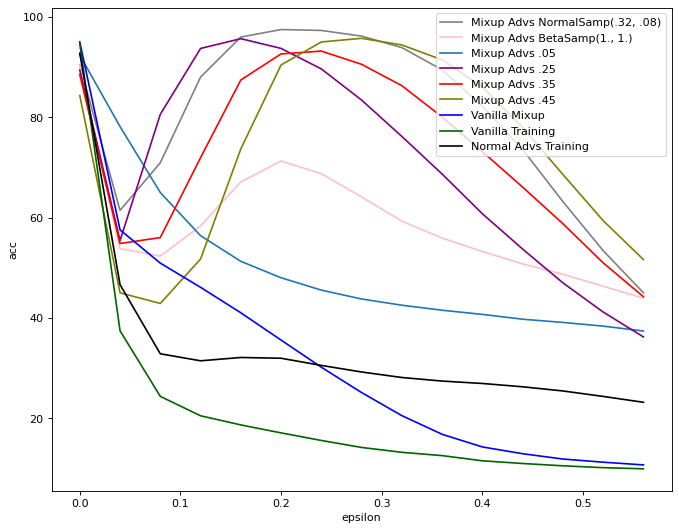

In [219]:
from matplotlib.pyplot import figure

figure(figsize=(10, 8), dpi=80)

plt.xlabel('epsilon'); plt.ylabel('acc');


plt.plot(eps_list, to_acc_tensor(err_SampEps_32_08), c='gray')
plt.plot(eps_list, to_acc_tensor(err_SampEpsBeta_1_1), c='pink')
plt.plot(eps_list, to_acc_tensor(err05))
plt.plot(eps_list, to_acc_tensor(err25), c='purple')
plt.plot(eps_list, to_acc_tensor(err35), c='r')
plt.plot(eps_list, to_acc_tensor(err45), c='olive')
plt.plot(eps_list, to_acc_tensor(err_mixup), c='b')
plt.plot(eps_list, to_acc_tensor(err_erm_noadvs), c = 'darkgreen')
plt.plot(eps_list, to_acc_tensor(err_norm_advs), c='black')

plt.legend(['Mixup Advs NormalSamp(.32, .08)', 'Mixup Advs BetaSamp(1., 1.)', 'Mixup Advs .05', 'Mixup Advs .25', 'Mixup Advs .35', 'Mixup Advs .45', 'Vanilla Mixup', 'Vanilla Training', 'Normal Advs Training']);

In [164]:
def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.imshow(npimg)
    plt.show()

In [337]:
best_acc

tensor(94.6600)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true labels is 1 
 adversaliral predicted is tensor([6]) 
 nomral is predictedtensor([1])


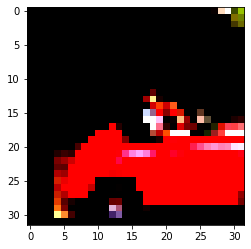

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


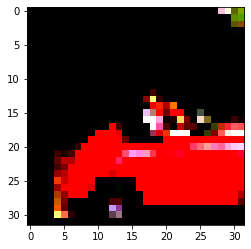

In [186]:
epsilon = .11
i = random.randint(0,100)
# i = 1


normal_inpt = trainset[i][0].reshape(1,3,32,32).cuda()
normal_inpt.requires_grad_(True)
out = net(normal_inpt)

target = torch.tensor([trainset[i][1]]).cuda()

loss = criterion(out, target)

optimizer.zero_grad()
loss.backward()

with torch.no_grad():
    advers_inp = normal_inpt + (epsilon * normal_inpt.grad.sign())
    advers_out = net(advers_inp)
    normal_out = net(normal_inpt)
    _,advs_predicted = torch.max(advers_out.cpu().data, 1)
    _,normal_predicted = torch.max(normal_out.cpu().data, 1)
    
print(f'true labels is {target.item()} \n adversaliral predicted is {advs_predicted} \n nomral is predicted{normal_predicted}')

imshow(normal_inpt.cpu().detach().squeeze())
imshow(advers_inp.cpu().detach().squeeze())

In [264]:
# advers_out = net(advers_inp) #+ (epsilon * normal_inpt.grad.sign())
# print(advers_out)
mx = 100
for j in range(1000):
    i = random.randint(0,3000)
    if torch.min(torch.min(trainset[i][0], -1)[0], -1)[0][0] < mx:
        mx = torch.min(torch.min(trainset[i][0], -1)[0], -1)[0][0]
mx

tensor(-2.4291)

In [281]:
import pandas as pd
df = pd.read_csv("results/log_ResNet_0_0.csv")
df

,epoch,train loss,reg loss,train acc,test loss,test acc
0,0,1.854828,0.0,tensor(35.1079),1.217799,tensor(57.0300)
1,1,1.580279,0.0,tensor(48.6740),0.930699,tensor(69.6800)
2,2,1.464894,0.0,tensor(54.0907),0.964110,tensor(68.2700)
3,3,1.409389,0.0,tensor(56.5027),0.768147,tensor(76.2700)
4,4,1.358588,0.0,tensor(58.5401),0.707272,tensor(78.8900)
...,...,...,...,...,...,...
195,195,0.770341,0.0,tensor(74.8484),0.297381,tensor(95.1700)
196,196,0.745491,0.0,tensor(75.9486),0.265202,tensor(95.3000)
197,197,0.749481,0.0,tensor(75.8501),0.252477,tensor(95.4300)
198,198,0.763400,0.0,tensor(75.3202),0.269733,tensor(95.2800)


In [297]:
torch.log(torch.tensor([torch.exp(torch.tensor(1.))]))

tensor([1.0000])